In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control  
import math

In [ ]:
# 1. PHYSICS CONSTANTS 
# ---------------------------------------------------------
M = 1.0     # Mass of Cart
m = 0.1     # Mass of Pole
l = 0.5     # Half-length of Pole
g = 9.8     # Gravity
dt = 0.02   # Time step

# 2. LINEARIZATION
# ---------------------------------------------------------
# We need to convert the complex physics into the form: x_dot = Ax + Bu
# The state vector x is [position, velocity, angle, angular_velocity]

# Denominator for the linearized equations (derived from physics)
denom = l * (4.0/3.0 - m / (m + M))

# Matrix A (System Dynamics)
# Represents how the state changes naturally if no force is applied
# Rows: x_dot, x_ddot, theta_dot, theta_ddot
A = np.array([
    [0, 1, 0, 0],                            # x_dot = x_dot
    [0, 0, -m*g/M, 0],                       # Linearized x_ddot
    [0, 0, 0, 1],                            # theta_dot = theta_dot
    [0, 0, g/denom, 0]                       # Linearized theta_ddot
])

# Matrix B (Control Input)
# Represents how the Force (u) affects the state
B = np.array([
    [0],
    [1/M],                                   # Force affects cart acceleration directly
    [0],
    [-1/(denom*(M+m))]                       # Force affects pole acceleration indirectly
])

In [3]:
# 3. LQR DESIGN
# ---------------------------------------------------------
# Q Matrix: State Cost (How much we punish errors)
# We punish Angle error (x[2]) heavily, and Position error (x[0]) moderately.
Q = np.diag([1.0, 1.0, 100.0, 1.0])

# R Matrix: Control Cost (How much we punish using Force)
# Low R means "Use as much force as you want to be perfect"
R = np.array([[0.1]])

# Calculate the Optimal Gain Matrix K
# K, S, E = control.lqr(A, B, Q, R)
# Note: If you don't have the 'control' lib, we can solve Riccati manually, 
# but installing 'control' is standard practice.
try:
    K, S, E = control.lqr(A, B, Q, R)
    print(f"Computed LQR Gain K:\n{K}")
except ImportError:
    print("Error: Please run 'pip install control' to calculate K automatically.")
    # Hardcoded K for these specific mass/length values if library is missing:
    K = np.array([[-10.0, -11.6, 52.6, 15.6]])

Computed LQR Gain K:
[[ -3.16227766  -6.60347985 -62.85295308 -14.39242164]]


In [4]:
# 4. SIMULATION LOOP (Non-Linear Physics)
# ---------------------------------------------------------
# We apply the Linear K to the Non-Linear Physics to prove it works.

# Initial State: [x=0, x_dot=0, theta=angle_rad rad (tilted), theta_dot=0]
angle_rad = 25 * 2 * math.pi / 360 # ~0.43 rad
state = np.array([0.0, 0.0, angle_rad, 0.0])

history_pos = []
history_angle = []
history_force = []
time_steps = []

steps = 300 # 6 seconds

print("\nStarting LQR Simulation...")

for i in range(steps):
    # --- A. CALCULATE CONTROL ---
    # u = -K * x
    # We must wrap angle to be continuous if we were doing a full swing-up, 
    # but for balancing small angles, raw state is fine.
    
    # Calculate force (scalar)
    u = -np.dot(K, state).item()
    
    # Clamp Force to realistic actuator limits (e.g., +/- 10N)
    u = np.clip(u, -10, 10)
    
    # --- B. UPDATE PHYSICS (Non-Linear) ---
    # (Exact same math as our PPO environment)
    x, x_dot, theta, theta_dot = state
    force = u
    
    costheta = math.cos(theta)
    sintheta = math.sin(theta)
    
    temp = (force + m * l * theta_dot**2 * sintheta) / (M + m)
    thetaacc = (g * sintheta - costheta * temp) / (l * (4.0/3.0 - m * costheta**2 / (M + m)))
    xacc = temp - m * l * thetaacc * costheta / (M + m)
    
    # Euler Integration
    x = x + dt * x_dot
    x_dot = x_dot + dt * xacc
    theta = theta + dt * theta_dot
    theta_dot = theta_dot + dt * thetaacc
    
    # Update State
    state = np.array([x, x_dot, theta, theta_dot])
    
    # Store Data
    time_steps.append(i * dt)
    history_pos.append(x)
    history_angle.append(theta)
    history_force.append(u)


Starting LQR Simulation...


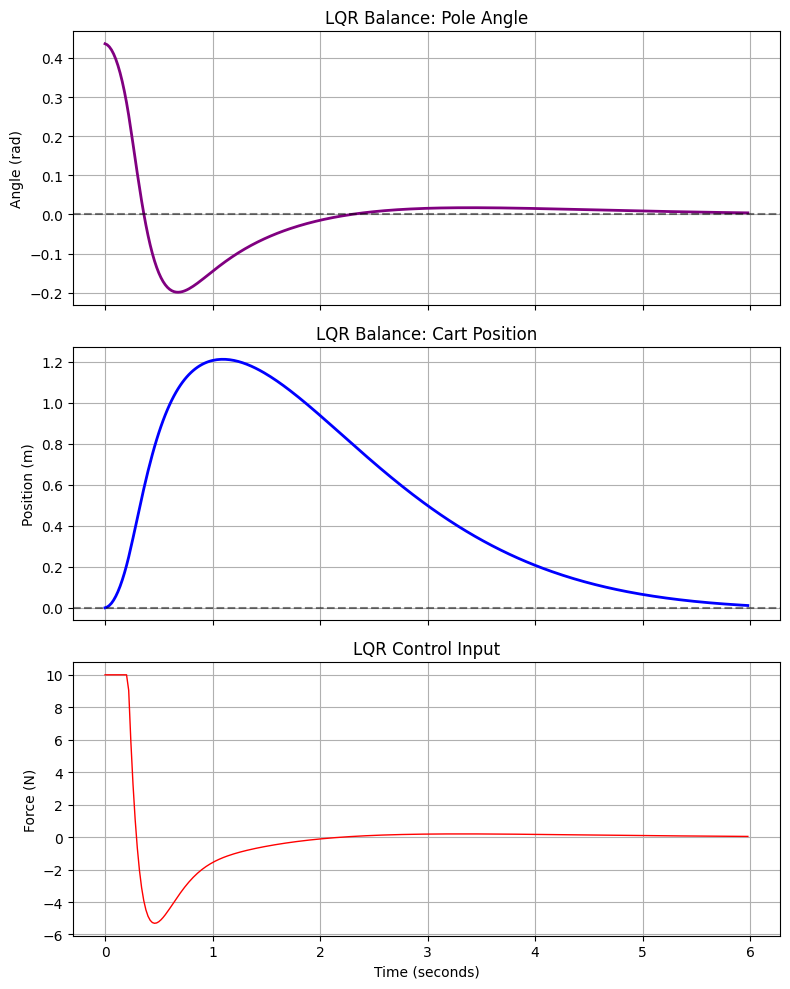

In [5]:
# 5. VISUALIZATION
# ---------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Angle
ax1.plot(time_steps, history_angle, color='purple', linewidth=2)
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_title("LQR Balance: Pole Angle")
ax1.set_ylabel("Angle (rad)")
ax1.grid(True)

# Position
ax2.plot(time_steps, history_pos, color='blue', linewidth=2)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_title("LQR Balance: Cart Position")
ax2.set_ylabel("Position (m)")
ax2.grid(True)

# Force
ax3.plot(time_steps, history_force, color='red', linewidth=1)
ax3.set_title("LQR Control Input")
ax3.set_ylabel("Force (N)")
ax3.set_xlabel("Time (seconds)")
ax3.grid(True)

plt.tight_layout()
plt.show()